# Autoencoders for Classification

Autoencoders are routinely used for feature extraction, to reduce the dimensionality of a dataset before training predictive models. 

In this notebook autoencoders themselves perform the prediction, in a binary classification task.

The trick is to train a separate AE for each class. In a two-class problem, AE_1 is trained to fit the input data of the first class, AE_2 fits the data of the second. You pass the testset through both AEs and measure the distances between the AEs' outputs and the true data. You assign each data instance to the class of the AE who exhibited the smallest reconstruction error.

In [2]:
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim

Generate train data. We visualize the first two features, although the dataset has ten features.

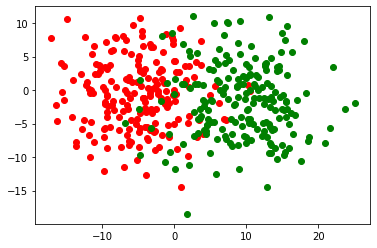

In [5]:
#make dataset
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

x,y = make_blobs(400,10,centers=2,cluster_std=5.5,random_state=33)
plt.scatter(x[y==0][:,0],x[y==0][:,1],c='red')
plt.scatter(x[y==1][:,0],x[y==1][:,1],c='green')

x_tr,x_ts,y_tr,y_ts = train_test_split(x,y,train_size=0.8,random_state=33)

Prepare the data for pytorch model training, and separate the training data according to class.

In [20]:
#turn data into tensors
tensor_tr = torch.FloatTensor(x_tr)
tensor_ts = torch.FloatTensor(x_ts)

#group data according to label
tr0 = tensor_tr[y_tr == 0]
tr1 = tensor_tr[y_tr == 1]

#make loads for model training
batch_size = 40
trainload_0 = DataLoader(tr0,batch_size=batch_size)
trainload_1 = DataLoader(tr1,batch_size=batch_size)

We design a simple AE architecture, consisting of linear layers activated by ReLUs. The output layer does not pass through any activation.

In [12]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10,5)
        self.layer2 = nn.Linear(5,2)
        self.layer3 = nn.Linear(2,5)
        self.out_layer = nn.Linear(5,10)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.out_layer(x)
        return x

Initialize parameters and AE models

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_epochs = 450
lr = 1e-3

loss_fn = nn.MSELoss()

model_0 = AE()
optimizer_0 = optim.Adam(model_0.parameters(),lr=lr)

model_1 = AE()
optimizer_1 = optim.Adam(model_1.parameters(),lr=lr)

Train first AE, for class 0:

In [21]:
model_0.to(device)
model_0.train()
agg_loss_0 = []

for epoch in range(1,n_epochs+1):
    epoch_loss_0 = 0
    for x in trainload_0:
        optimizer_0.zero_grad()
        preds = model_0(x)
        
        #the loss is measured not with a label but with the input itself
        loss = loss_fn(preds,x)
        
        loss.backward()
        optimizer_0.step()
        epoch_loss_0 += loss        
    epoch_loss_0 = epoch_loss_0/len(trainload_0)
    
    #list with loss of each epoch, for visualization
    agg_loss_0.append(epoch_loss_0)
    
    print(f'epoch: {epoch+0:03}  |  loss: {epoch_loss_0}')

epoch: 001 | loss: 60.02309036254883
epoch: 002 | loss: 59.76337814331055
epoch: 003 | loss: 59.533302307128906
epoch: 004 | loss: 59.31587600708008
epoch: 005 | loss: 59.102821350097656
epoch: 006 | loss: 58.887908935546875
epoch: 007 | loss: 58.66435623168945
epoch: 008 | loss: 58.42558670043945
epoch: 009 | loss: 58.16558074951172
epoch: 010 | loss: 57.87537384033203
epoch: 011 | loss: 57.5452880859375
epoch: 012 | loss: 57.169036865234375
epoch: 013 | loss: 56.73150634765625
epoch: 014 | loss: 56.22493362426758
epoch: 015 | loss: 55.63056564331055
epoch: 016 | loss: 54.9481086730957
epoch: 017 | loss: 54.17247772216797
epoch: 018 | loss: 53.2896842956543
epoch: 019 | loss: 52.31407928466797
epoch: 020 | loss: 51.25567626953125
epoch: 021 | loss: 50.13694763183594
epoch: 022 | loss: 48.98583221435547
epoch: 023 | loss: 47.82985305786133
epoch: 024 | loss: 46.70164108276367
epoch: 025 | loss: 45.62776184082031
epoch: 026 | loss: 44.63059616088867
epoch: 027 | loss: 43.712547302246094

Train second AE, for class 1:

In [22]:
model_1.to(device)
model_1.train()
agg_loss_1 = []

for epoch in range(1,n_epochs+1):
    epoch_loss_1 = 0
    for x in trainload_1:
        optimizer_1.zero_grad()
        preds = model_1(x)
        
        #the loss is measured not with a label but with the input itself
        loss = loss_fn(preds,x)
        
        loss.backward()
        optimizer_1.step()
        epoch_loss_1 += loss
    epoch_loss_1 = epoch_loss_1/len(trainload_1)
    
    #list with loss of each epoch, for visualization
    agg_loss_1.append(epoch_loss_1)
    
    print(f'epoch: {epoch+0:03}  |  loss: {epoch_loss_1}')

epoch: 001 | loss: 68.38768005371094
epoch: 002 | loss: 67.80103302001953
epoch: 003 | loss: 67.17576599121094
epoch: 004 | loss: 66.52336120605469
epoch: 005 | loss: 65.86587524414062
epoch: 006 | loss: 65.2193603515625
epoch: 007 | loss: 64.60176086425781
epoch: 008 | loss: 63.98468017578125
epoch: 009 | loss: 63.37232971191406
epoch: 010 | loss: 62.75152587890625
epoch: 011 | loss: 62.12285232543945
epoch: 012 | loss: 61.48584747314453
epoch: 013 | loss: 60.82476043701172
epoch: 014 | loss: 60.13494873046875
epoch: 015 | loss: 59.40858459472656
epoch: 016 | loss: 58.64019775390625
epoch: 017 | loss: 57.82573699951172
epoch: 018 | loss: 56.96546936035156
epoch: 019 | loss: 56.061180114746094
epoch: 020 | loss: 55.11119079589844
epoch: 021 | loss: 54.114479064941406
epoch: 022 | loss: 53.07422637939453
epoch: 023 | loss: 51.99359130859375
epoch: 024 | loss: 50.87760925292969
epoch: 025 | loss: 49.73113250732422
epoch: 026 | loss: 48.558876037597656
epoch: 027 | loss: 47.36939239501953

Visualize loss curves:

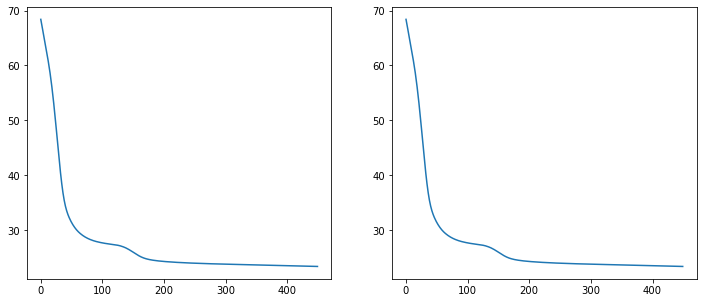

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(agg_loss_1)
plt.title('Loss curve for class0 AE')

plt.subplot(1,2,2)
plt.plot(agg_loss_1)
plt.title('Loss curve for class1 AE')

Generate predictions and measure accuracy:

In [41]:
preds = []

for x in tensor_ts:
    #pass data through AE_0
    pr0 = model_0(x)
    l0 = loss_fn(pr0,x)
    
    #pass data through AE_1
    pr1 = model_1(x)
    l1 = loss_fn(pr1,x)
    
    #assign each instance in class of AE with smallest reconstruction error
    prediction = 0 if l0<l1 else 1
    preds.append(prediction)    
    
print('accuracy:',accuracy_score(preds,y_ts))

accuracy: 1.0
